In [1]:
import pandas as pd
import numpy as np
import holidays
from stop_words import get_stop_words                       
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition, preprocessing, ensemble, metrics, linear_model, model_selection, neighbors, feature_selection
import category_encoders
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import joblib
import datetime
import xgboost
import shap
import gc
from math import sqrt
import lightgbm as lgb
from operator import itemgetter
from ax.service.managed_loop import optimize
from functools import partial
import catboost as cat

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

seed = 42

In [2]:
def downcast_columns(df):
    for col in df.columns:
        if(df[col].dtype == "int64"):
            if((df[col].min() > -128) & (df[col].max() < 127)):
                df[col] = df[col].astype("int8")
            elif((df[col].min() > -32768) & (df[col].max() < 32767)):   
                df[col] = df[col].astype("int16")
            elif((df[col].min() > -2147483648) & (df[col].max() < 2147483647)):   
                df[col] = df[col].astype("int32")
        elif(df[col].dtype == "float64"):
            if(df[col].apply(float.is_integer).all()):
                if((df[col].min() > -128) & (df[col].max() < 127)):
                    df[col] = df[col].astype("int8")
                elif((df[col].min() > -32768) & (df[col].max() < 32767)):   
                    df[col] = df[col].astype("int16")
                elif((df[col].min() > -2147483648) & (df[col].max() < 2147483647)):   
                    df[col] = df[col].astype("int32")
            elif((df[col].min() > -65504.0) & (df[col].max() < 65504.0)):
                df[col] = df[col].astype("float16")
            elif((df[col].min() > -3.4028235*(10**38)) & (df[col].max() < 3.4028235*(10**38))):   
                df[col] = df[col].astype("float32")

    return df

## EDA

In [51]:
df_sales = pd.read_csv("dataset/sales_train.csv")
df_shops = pd.read_csv("dataset/shops.csv")
df_items_categories = pd.read_csv("dataset/item_categories.csv")
df_items = pd.read_csv("dataset/items.csv")
df_test = pd.read_csv("dataset/test.csv")

In [52]:
df_report = pd.merge(df_sales, df_shops, on="shop_id", how="left")
df_report = pd.merge(df_report, df_items, on="item_id", how="left")
df_report = pd.merge(df_report, df_items_categories, on="item_category_id", how="left")
df_report = pd.merge(df_report, df_test, on=["shop_id", "item_id"], how="inner")

df_test = df_test.set_index('ID')

In [53]:
df_report.drop(["ID"], axis=1, inplace=True)

In [54]:
df_report.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
shop_name              object
item_name              object
item_category_id        int64
item_category_name     object
dtype: object

In [55]:
df_report.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2574,399.0,2.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
2,05.01.2013,0,25,2574,399.0,1.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
3,07.01.2013,0,25,2574,399.0,1.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
4,08.01.2013,0,25,2574,399.0,2.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства


In [56]:
df_report.describe().round(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,1224439.00,1224439.00,1224439.00,1224439.00,1224439.00,1224439.00
mean,19.35,32.15,9614.87,1030.67,1.32,40.56
std,9.11,16.47,6299.87,1827.38,3.31,18.61
min,0.00,2.00,30.00,0.50,-16.00,2.00
25%,12.00,19.00,4181.00,299.00,1.00,25.00
50%,21.00,31.00,7856.00,549.00,1.00,38.00
75%,27.00,46.00,15229.00,1199.00,1.00,55.00
max,33.00,59.00,22167.00,59200.00,2169.00,83.00


In [57]:
df_total = df_report.isnull().sum().sort_values(ascending=False)
df_percent = (df_report.isnull().sum()/df_report.isnull().count()).sort_values(ascending=False)
df_missing_data = pd.concat([df_total, df_percent], axis=1, keys=['total', 'percent'])
df_missing_data.head(5)

,total,percent
item_category_name,0,0.0
item_category_id,0,0.0
item_name,0,0.0
shop_name,0,0.0
item_cnt_day,0,0.0


In [58]:
cols=[]
nunique=[]
for col in df_report.columns:
    if(str(df_report[col].dtype) == "object"):
        cols.append(col)
        nunique.append(int(df_report[col].nunique()))
    
pd.DataFrame({"nunique": nunique}, index=cols).sort_values("nunique",ascending=False)

,nunique
item_name,4716
date,1034
item_category_name,60
shop_name,42


<AxesSubplot:xlabel='item_cnt_day'>

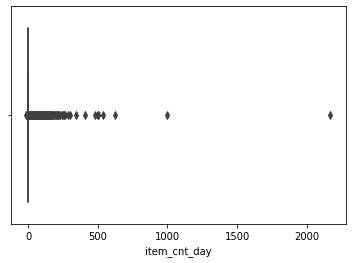

In [59]:
sns.boxplot(df_report['item_cnt_day'])

<AxesSubplot:xlabel='item_price'>

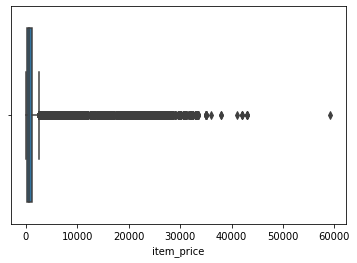

In [60]:
sns.boxplot(df_report['item_price'])

In [61]:
df_train = df_report

## Remove Outliers

In [62]:
def remove_outlier(x_train, y_train=None, targert_name="target", isolation_forest=False, seed=666):
    if(isolation_forest):
        if(os.path.exists("model_isolation_forest.joblib")):
            model_if = joblib.load('model_isolation_forest.joblib')
        else:
            model_if = ensemble.IsolationForest(n_estimators=500, max_features=x_train.shape[1], n_jobs=-1, random_state=seed)
            model_if.fit(x_train)

            joblib.dump(model_if, 'model_isolation_forest.joblib') 

        x_train["outlier"] = model_if.predict(x_train)
        x_train[targert_name] = y_train

        condf = x_train["outlier"] == 1
        
        if(y_train == None):
            x_train = x_train.loc[condf].drop([targert_name, "outlier"], axis=1)
            return x_train
        else:
            y_train = x_train.loc[condf][targert_name].values
            x_train = x_train.loc[condf].drop([targert_name, "outlier"], axis=1)
            return x_train, y_train 
    else:
        data_mean, data_std = np.mean(x_train), np.std(x_train)

        cut_off = data_std * 3

        lower = data_mean - cut_off
        upper = data_mean + cut_off
        
        cond1 = x_train <= lower
        cond2 = x_train >= upper
        condf = (cond1 | cond2).any(axis=1)

        x_train[targert_name] = y_train
        
        if(y_train == None):
            x_train = x_train.loc[~condf].drop([targert_name], axis=1)
            return x_train
        else:
            y_train = x_train.loc[~condf][targert_name].values
            x_train = x_train.loc[~condf].drop([targert_name], axis=1)
            return x_train, y_train 

In [63]:
cols = [
    "date_block_num",
    "shop_id",
    "item_id",
    "item_price", 
    "item_category_id",
    "index"
]

df_train_orig = df_train[["shop_name", "item_name", "item_category_name", "date", "item_cnt_day"]]
df_train_orig["index"] = df_train_orig.index

df_train["index"] = df_train.index
df_train  = remove_outlier(df_train[cols], isolation_forest=True)
df_train[cols].shape

df_train = pd.merge(df_train, df_train_orig, on=["index"], how="inner").drop(["index"], axis=1)
del df_train_orig

<AxesSubplot:xlabel='item_price'>

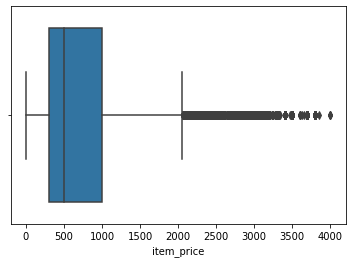

In [64]:
sns.boxplot(df_train['item_price'])

<AxesSubplot:xlabel='item_cnt_day'>

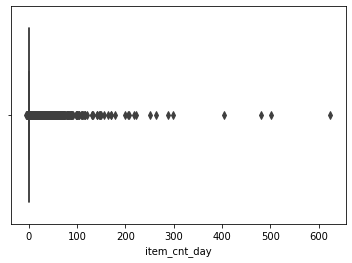

In [65]:
sns.boxplot(df_train['item_cnt_day'])

In [66]:
df_train = df_report

## Date Preprocessing

In [67]:
df_train["date"] = pd.to_datetime(df_train["date"], format='%d.%m.%Y')
df_train["year"] = df_train["date"].dt.year
df_train["month"] = df_train["date"].dt.month

## Grid

In [68]:
grid_list = []
df_train["key"] = 1
for block_num in df_train['date_block_num'].unique():
    cond = df_train["date_block_num"] == block_num

    df_train_date = df_train.loc[cond].groupby(["date_block_num"]).agg({"key": "first"}).reset_index()
    df_train_shop = df_train.loc[cond].groupby(["shop_id"]).agg({"key": "first"}).reset_index()
    df_train_item = df_train.loc[cond].groupby(["item_id"]).agg({"key": "first"}).reset_index()

    df_train_item = pd.merge(df_train_shop, df_train_item, on="key", how="inner")
    df_train_item_date = pd.merge(df_train_date, df_train_item, on="key", how="inner")
    grid_list.append(df_train_item_date)

    del (df_train_date, df_train_item_date)

df_grid = pd.concat(grid_list, axis=0, ignore_index=True)

del grid_list 

df_grid = downcast_columns(df_grid)

agg_group = {
    "item_cnt_day": "sum",
    "item_price": "sum",
    "year": "max",
    "month": "max",
}

df_train_grouped = df_train.groupby(['date_block_num','shop_id','item_id']).agg(agg_group).reset_index()

df_train_final = pd.merge(df_grid, df_train_grouped, on=['date_block_num', 'shop_id', 'item_id'], how='left')

month = 1
year = 2013
for block_num in df_train['date_block_num'].unique():
    cond1 = df_train_final["date_block_num"] == block_num
    cond2 = df_train_final["year"].isnull()
    cond3 = df_train_final["month"].isnull()
    df_train_final.loc[cond1 & cond2, "month"] = month
    df_train_final.loc[cond1 & cond3, "year"] = year
    if(month == 12):
        month = 1
        year += 1
    month += 1

df_train_final = df_train_final.fillna(0)

df_train_final = pd.merge(df_train_final, df_items, on=['item_id'], how='left')
df_train_final = pd.merge(df_train_final, df_items_categories, on=['item_category_id'], how='left')
df_train_final = pd.merge(df_train_final, df_shops, on=['shop_id'], how='left')

df_train_final = df_train_final.drop(["key"], axis=1)

df_train = downcast_columns(df_train_final)

In [69]:
cond1 = df_train["item_cnt_day"] < 0
cond2 = df_train["item_cnt_day"] > 20

df_train.loc[cond1, "item_cnt_day"] = 0
df_train.loc[cond2, "item_cnt_day"] = 20

In [70]:
df_train.shape

(2731818, 11)

In [71]:
df_train.dtypes

date_block_num           int8
shop_id                  int8
item_id                 int16
item_cnt_day            int16
item_price            float32
year                    int16
month                    int8
item_name              object
item_category_id         int8
item_category_name     object
shop_name              object
dtype: object

In [72]:
df_test["month"] = 11
df_test["year"] = 2015
df_test["date_block_num"] = 34

df_test = pd.merge(df_test, df_shops, on="shop_id", how="left")
df_test = pd.merge(df_test, df_items, on="item_id", how="left")
df_test = pd.merge(df_test, df_items_categories, on="item_category_id", how="left")

df_train = pd.concat([df_train, df_test], axis=0)

df_train.fillna(0, inplace=True)

## Preprocessing

In [73]:
df_train["shop_name"] = df_train["shop_name"].str.replace(r"\!", "").str.strip()
df_train["city"] = df_train["shop_name"].str.split(" ").str[0]

df_train["macro_item_category_name"] = df_train["item_category_name"].str.replace(r"(.*)\s{1}(\-|\().*", r"\1").str.strip()

df_train["city"] = df_train["city"].astype("category").cat.codes
df_train["macro_item_category_name"] = df_train["macro_item_category_name"].astype("category").cat.codes

df_train.drop(["item_name", "item_category_name", "shop_name"], axis=1, inplace=True)

## Date Features

In [74]:
month = 1
year = 2013
holidays_map = {}
rus_holidays = holidays.Russia()

for i in range(len(df_report["date_block_num"].unique())+1):
    if(month <= 9):
        month_str = "0" + str(month)
    else:
        month_str = str(month)
        
    dt_init = str(year) + "-" + month_str + "-01"
    dt_end = pd.date_range(start=dt_init, periods=1, freq=pd.offsets.MonthEnd(1))[0]

    list_date = pd.date_range(start=dt_init, end=dt_end)
    
    count_holidays = 0
    for dt in list_date:
        dt_str = str(dt).split(" ")[0]
        if(dt_str in rus_holidays):
            count_holidays += 1
    
    holidays_map[str(year)+"_"+str(month)] = count_holidays
     
    if(month == 12):
        month = 1
        year += 1
    else:
        month += 1
        
for key, value in holidays_map.items():
    year,month = key.split("_")
    cond1 = df_train["month"] == int(month)
    cond2 = df_train["year"] == int(year)
    condf = cond1 & cond2
    df_train.loc[condf, "qty_holidays"] = value

In [75]:
df_train['month_sin'] = np.sin((df_train["month"]-1)*(2.*np.pi/12))
df_train['month_cos'] = np.cos((df_train["month"]-1)*(2.*np.pi/12))

## Price Features

In [76]:
df_group = df_report.groupby(['item_id']).agg({'item_price': 'mean'}).reset_index()
df_group.rename(columns={'item_price': 'item_avg_item_price'}, inplace=True)

df_train = pd.merge(df_train, df_group, on=['item_id'], how='left')

df_group = df_report.groupby(['date_block_num','item_id']).agg({'item_price': 'mean'}).reset_index()
df_group.rename(columns={'item_price': 'date_item_avg_item_price'}, inplace=True)

df_train = pd.merge(df_train, df_group, on=['date_block_num','item_id'], how='left')

df_tmp = df_train[['date_block_num','shop_id','item_id', "date_item_avg_item_price"]].copy()

lags = [1, 2, 3, 4, 5, 6]

for lag in lags:
    df_tmp_lag = df_tmp.copy()
    df_tmp_lag.columns = ['date_block_num','shop_id','item_id','date_item_avg_item_price_lag_'+ str(lag)]
    df_tmp_lag['date_block_num'] += lag
    df_train = pd.merge(df_train, df_tmp_lag, on=['date_block_num','shop_id','item_id'], how='left')
    
for lag in lags:
    df_train['delta_price_lag_' + str(lag)] = (df_train['date_item_avg_item_price_lag_' + str(lag)] - df_train['item_avg_item_price']) / df_train['item_avg_item_price']

def select_feat(row):
    for lag in lags:
        if row['delta_price_lag_'+str(lag)]:
            return row['delta_price_lag_'+str(lag)]
    return 0
    
df_train['delta_price_lag'] = df_train.apply(select_feat, axis=1)
df_train['delta_price_lag'].fillna(0, inplace=True)

cols_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for lag in lags:
    cols_to_drop += ['date_item_avg_item_price_lag_'+str(lag)]
    cols_to_drop += ['delta_price_lag_'+str(lag)]

df_train.drop(cols_to_drop, axis=1, inplace=True)

In [78]:
df_tmp = df_train.groupby(["item_category_id", "date_block_num"]).agg({"item_price": "mean"}).reset_index()
df_tmp = df_tmp.rename({'item_price': 'category_mean_item_price'}, axis=1)
df_train = pd.merge(df_train, df_tmp, on=["item_category_id", "date_block_num"], how="left")

df_tmp = df_train.groupby(["city", "date_block_num"]).agg({"item_price": "mean"}).reset_index()
df_tmp = df_tmp.rename({'item_price': 'city_mean_item_price'}, axis=1)
df_train = pd.merge(df_train, df_tmp, on=["city", "date_block_num"], how="left")

df_tmp = df_train.groupby(["macro_item_category_name", "date_block_num"]).agg({"item_price": "mean"}).reset_index()
df_tmp = df_tmp.rename({'item_price': 'macro_category_mean_item_price'}, axis=1)
df_train = pd.merge(df_train, df_tmp, on=["macro_item_category_name", "date_block_num"], how="left")

df_tmp = df_train.groupby(["item_id", "date_block_num"]).agg({"item_price": "mean"}).reset_index()
df_tmp = df_tmp.rename({'item_price': 'item_id_mean_item_price'}, axis=1)
df_train = pd.merge(df_train, df_tmp, on=["item_id", "date_block_num"], how="left")

##########################################################################################################

df_tmp = df_train.groupby(["shop_id", "date_block_num"]).agg({"item_cnt_day": "sum"}).reset_index()
df_tmp = df_tmp.rename({'item_cnt_day': 'shop_sum_item_cnt_day'}, axis=1)
df_train = pd.merge(df_train, df_tmp, on=["shop_id", "date_block_num"], how="left")

df_tmp = df_train.groupby(["macro_item_category_name", "date_block_num"]).agg({"item_cnt_day": "sum"}).reset_index()
df_tmp = df_tmp.rename({'item_cnt_day': 'macro_cat_sum_item_cnt_day'}, axis=1)
df_train = pd.merge(df_train, df_tmp, on=["macro_item_category_name", "date_block_num"], how="left")

df_tmp = df_train.groupby(["city", "date_block_num"]).agg({"item_cnt_day": "sum"}).reset_index()
df_tmp = df_tmp.rename({'item_cnt_day': 'city_sum_item_cnt_day'}, axis=1)
df_train = pd.merge(df_train, df_tmp, on=["city", "date_block_num"], how="left")

df_tmp = df_train.groupby(["item_id", "date_block_num"]).agg({"item_cnt_day": "sum"}).reset_index()
df_tmp = df_tmp.rename({'item_cnt_day': 'item_id_sum_item_cnt_day'}, axis=1)
df_train = pd.merge(df_train, df_tmp, on=["item_id", "date_block_num"], how="left")

In [79]:
df_train['item_price_log'] = (df_train['item_price']- df_train['item_price'].min()+1).transform(np.log)

In [80]:
df_train.describe()

,date_block_num,shop_id,item_id,item_cnt_day,item_price,year,month,item_category_id,city,macro_item_category_name,qty_holidays,month_sin,month_cos,delta_price_lag,category_mean_item_price,city_mean_item_price,macro_category_mean_item_price,item_id_mean_item_price,shop_sum_item_cnt_day,macro_cat_sum_item_cnt_day,city_sum_item_cnt_day,item_id_sum_item_cnt_day,item_price_log
count,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.808588e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06,2.946018e+06
mean,2.197192e+01,3.127529e+01,1.083542e+04,4.641156e-01,4.283705e+02,2.014368e+03,7.529820e+00,4.622539e+01,1.385233e+01,1.149711e+01,7.548612e-01,-1.395023e-01,-2.157274e-02,-2.177467e-03,4.283708e+02,4.283708e+02,4.283708e+02,4.283707e+02,1.047436e+03,5.871051e+03,3.285493e+03,1.840919e+01,1.368962e+00
std,9.414038e+00,1.782594e+01,6.233339e+03,1.602737e+00,3.276440e+03,7.593762e-01,3.286657e+00,1.620432e+01,7.459434e+00,4.063620e+00,1.321131e+00,7.243953e-01,6.747781e-01,2.166074e-01,2.382733e+03,2.705515e+02,2.033161e+03,2.684456e+03,8.733076e+02,3.755668e+03,5.101488e+03,4.555617e+01,2.762705e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-9.963345e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,1.600000e+01,5.128000e+03,0.000000e+00,0.000000e+00,2.014000e+03,5.000000e+00,3.700000e+01,9.000000e+00,1.100000e+01,0.000000e+00,-8.660254e-01,-5.000000e-01,-2.857932e-02,7.809849e+01,2.483746e+02,9.289207e+01,2.187805e+01,5.930000e+02,3.648000e+03,7.390000e+02,2.000000e+00,0.000000e+00
50%,2.400000e+01,3.400000e+01,1.090800e+04,0.000000e+00,0.000000e+00,2.015000e+03,8.000000e+00,4.700000e+01,1.300000e+01,1.200000e+01,1.000000e+00,-5.000000e-01,-1.836970e-16,0.000000e+00,1.149472e+02,3.796313e+02,1.319561e+02,6.294737e+01,8.760000e+02,5.985000e+03,1.183000e+03,6.000000e+00,0.000000e+00
75%,3.000000e+01,4.700000e+01,1.605700e+04,0.000000e+00,0.000000e+00,2.015000e+03,1.100000e+01,5.700000e+01,2.000000e+01,1.400000e+01,1.000000e+00,5.000000e-01,5.000000e-01,2.075294e-02,3.215007e+02,5.823506e+02,3.726937e+02,2.118317e+02,1.204000e+03,7.849000e+03,2.312000e+03,1.600000e+01,0.000000e+00
max,3.400000e+01,5.900000e+01,2.216700e+04,2.000000e+01,5.155736e+05,2.015000e+03,1.200000e+01,8.300000e+01,2.700000e+01,2.300000e+01,8.000000e+00,1.000000e+00,1.000000e+00,4.662775e+00,3.031758e+05,1.695861e+03,3.031758e+05,3.031758e+05,8.065000e+03,2.301100e+04,2.746500e+04,8.000000e+02,1.315304e+01


In [81]:
df_train = downcast_columns(df_train)

In [82]:
gc.collect()

30

In [83]:
df_train = downcast_columns(df_train)
df_train.shape

(2946018, 23)

## Mean Enconding

In [84]:
def mean_encondig(df, group_cols, target_column, new_col):
    df_group = df.groupby(group_cols).agg({target_column: 'mean'}).reset_index()
    df_group = df_group.rename({target_column: new_col}, axis=1)

    df = pd.merge(df, df_group, on=group_cols, how='left')
    return df

In [85]:
mean_cols = {
    "item_id_mean": ["date_block_num", "item_id"],
    "shop_id_mean": ["date_block_num", "shop_id"],
    "item_category_id_mean": ["date_block_num", "item_category_id"],
    "city_mean": ["date_block_num", "city"],
    "macro_item_category_name_mean": ["date_block_num", "macro_item_category_name"],
    "date_block_num_mean": ["date_block_num"],
    "shop_category_mean": ['date_block_num', 'shop_id', 'item_category_id'],
    "shop_macro_category_mean": ['date_block_num', 'shop_id', 'macro_item_category_name'],
    "item_city_mean": ['date_block_num', 'item_id', 'city']
}

for new_col, group_cols in mean_cols.items():
    df_train = mean_encondig(df_train, group_cols, "item_cnt_day", new_col)

In [86]:
df_train = downcast_columns(df_train)

In [87]:
df_train.fillna(0, inplace=True)

## Lag Features

In [88]:
def create_lag_features(df, col, lags=[1,2,3,6,12], drop=False):  
    df_lag = df[['date_block_num','shop_id','item_id',col]].copy()
    for lag in lags:
        df_lag_tmp = df_lag.copy()
        df_lag_tmp['date_block_num'] += lag
        df_lag_tmp.columns = ['date_block_num','shop_id','item_id', col + '_lag_'+ str(lag)]
        
        df_lag_tmp["key"] = df_lag_tmp["date_block_num"].astype(str) + "_" + df_lag_tmp["shop_id"].astype(str) + "_" + df_lag_tmp["item_id"].astype(str)
        df_lag_tmp.set_index('key', inplace=True)
        df_lag_tmp.drop(['date_block_num','shop_id','item_id'], axis=1, inplace=True)
    
        df = df.join(df_lag_tmp, how='left')

    if(drop):
        df.drop([col], axis=1, inplace=True)
        
    df.fillna(0, inplace=True)
    return df

In [89]:
df_train["key"] = df_train["date_block_num"].astype(str) + "_" + df_train["shop_id"].astype(str) + "_" + df_train["item_id"].astype(str)

df_train.set_index('key', inplace=True)

lag_features = {
    "item_cnt_day": [False, [1,2,3,6,12]],
    "item_price": [True, [1,2,3,6,12]],
    "category_mean_item_price": [True, [1,2,3]],
    "city_mean_item_price": [True, [1,2,3]],
    "macro_category_mean_item_price": [True, [1,2,3]],
    "item_id_mean_item_price": [True, [1,2,3]],
    "shop_sum_item_cnt_day": [True, [1,2,3]],
    "macro_cat_sum_item_cnt_day": [True, [1,2,3]],
    "city_sum_item_cnt_day": [True, [1,2,3]],
    "item_id_sum_item_cnt_day":[True, [1,2,3]],
    "item_price_log":[True, [1,2,3]],
    "item_id_mean":[True, [1,2,3,6,12]],
    "shop_id_mean":[True, [1,2,3,6,12]],
    "item_category_id_mean": [True, [1,2,3,6,12]],
    "city_mean": [True, [1,2,3,6,12]],
    "macro_item_category_name_mean": [True, [1,2,3,6,12]],
    "date_block_num_mean":[True, [1,2,3,6,12]],
    "shop_category_mean":[True, [1]],
    "shop_macro_category_mean": [True, [1]],
    "item_city_mean": [True, [1]]
}

for col, param in lag_features.items():
    df_train = create_lag_features(df_train, col, lags=param[1], drop=param[0])    
    df_train = downcast_columns(df_train)

In [90]:
joblib.dump(df_train, 'df_train_sample.joblib')

['df_train_sample.joblib']

In [91]:
del df_report
del df_train
del df_tmp
del df_train_final
del df_test
del df_sales
del df_shops
del df_items_categories
del df_items

gc.collect()

30

# Training Model

In [3]:
df_train = joblib.load('df_train_sample.joblib')

In [4]:
df_train

,date_block_num,shop_id,item_id,item_cnt_day,year,month,item_category_id,city,macro_item_category_name,qty_holidays,month_sin,month_cos,delta_price_lag,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_6,item_cnt_day_lag_12,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_6,item_price_lag_12,category_mean_item_price_lag_1,category_mean_item_price_lag_2,category_mean_item_price_lag_3,city_mean_item_price_lag_1,city_mean_item_price_lag_2,city_mean_item_price_lag_3,macro_category_mean_item_price_lag_1,macro_category_mean_item_price_lag_2,macro_category_mean_item_price_lag_3,item_id_mean_item_price_lag_1,item_id_mean_item_price_lag_2,item_id_mean_item_price_lag_3,shop_sum_item_cnt_day_lag_1,shop_sum_item_cnt_day_lag_2,shop_sum_item_cnt_day_lag_3,macro_cat_sum_item_cnt_day_lag_1,macro_cat_sum_item_cnt_day_lag_2,macro_cat_sum_item_cnt_day_lag_3,city_sum_item_cnt_day_lag_1,city_sum_item_cnt_day_lag_2,city_sum_item_cnt_day_lag_3,item_id_sum_item_cnt_day_lag_1,item_id_sum_item_cnt_day_lag_2,item_id_sum_item_cnt_day_lag_3,item_price_log_lag_1,item_price_log_lag_2,item_price_log_lag_3,item_id_mean_lag_1,item_id_mean_lag_2,item_id_mean_lag_3,item_id_mean_lag_6,item_id_mean_lag_12,shop_id_mean_lag_1,shop_id_mean_lag_2,shop_id_mean_lag_3,shop_id_mean_lag_6,shop_id_mean_lag_12,item_category_id_mean_lag_1,item_category_id_mean_lag_2,item_category_id_mean_lag_3,item_category_id_mean_lag_6,item_category_id_mean_lag_12,city_mean_lag_1,city_mean_lag_2,city_mean_lag_3,city_mean_lag_6,city_mean_lag_12,macro_item_category_name_mean_lag_1,macro_item_category_name_mean_lag_2,macro_item_category_name_mean_lag_3,macro_item_category_name_mean_lag_6,macro_item_category_name_mean_lag_12,date_block_num_mean_lag_1,date_block_num_mean_lag_2,date_block_num_mean_lag_3,date_block_num_mean_lag_6,date_block_num_mean_lag_12,shop_category_mean_lag_1,shop_macro_category_mean_lag_1,item_city_mean_lag_1
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_2_32,0,2,32,0,2013,1,40,0,11,8.0,0.000000,1.0,0.000000,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0_2_33,0,2,33,1,2013,1,37,0,11,8.0,0.000000,1.0,0.000000,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0_2_42,0,2,42,0,2013,1,57,0,14,8.0,0.000000,1.0,0.000000,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0_2_45,0,2,45,0,2013,1,57,0,14,8.0,0.000000,1.0,0.000000,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.

In [5]:
cond1 = df_train["date_block_num"] > 11
cond2 = df_train["date_block_num"] <= 32
cond3 = df_train["date_block_num"] == 33
cond4 = df_train["date_block_num"] == 34

df_dev = df_train.loc[cond3]
df_test = df_train.loc[cond4]
df_train = df_train.loc[cond1 & cond2]

df_train = downcast_columns(df_train)
df_dev = downcast_columns(df_dev)
df_test = downcast_columns(df_test)

In [6]:
x_train = df_train.drop(["item_cnt_day"], axis=1)
y_train = df_train["item_cnt_day"].values

x_dev = df_dev.drop(["item_cnt_day"], axis=1)
y_dev = df_dev["item_cnt_day"].values

x_test = df_test.drop(["item_cnt_day"], axis=1)

In [7]:
model_minmax = preprocessing.MinMaxScaler()
x_train_norm = model_minmax.fit_transform(x_train)
x_dev_norm = model_minmax.transform(x_dev)
x_test_norm = model_minmax.transform(x_test)

## Feature Selection

In [8]:
model_lgb = lgb.LGBMRegressor(random_state=seed, n_jobs=-1)
model_lgb.fit(x_train, y_train, eval_metric="rmse", eval_set=[(x_train, y_train), (x_dev, y_dev)], verbose=False, early_stopping_rounds = 40)

LGBMRegressor(random_state=42)

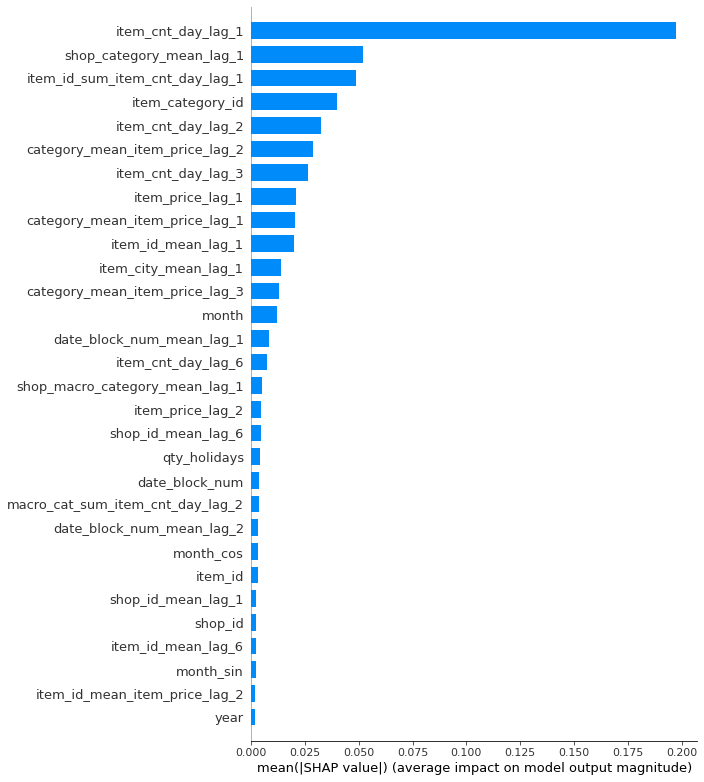

In [9]:
shap.initjs()
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar", max_display=30)

In [10]:
vals= np.abs(shap_values).mean(0)
df_feature_importance = pd.DataFrame(list(zip(x_train.columns,vals)),columns=['col_name','feature_importance_vals'])
df_feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
cols = df_feature_importance.head(30)["col_name"].values

x_train = x_train[cols]
x_dev = x_dev[cols]
x_test = x_test[cols]

## Tuning Hyperparameters

### LightGBM

In [11]:
def train_evaluate(parameterization):
    model_lgb = lgb.LGBMRegressor(**parameterization, random_state=seed, n_jobs=-1)
    model_lgb.fit(x_train, y_train, eval_metric="rmse", eval_set=[(x_train, y_train), (x_dev, y_dev)], verbose=False, early_stopping_rounds = 30)

    pred = model_lgb.predict(x_dev)
    metric = sqrt(metrics.mean_squared_error(y_dev, pred))
    
    print(metric)
    
    return metric


best_param_lgb, values, experiment, model = optimize(
    parameters=[
        {"name": "n_estimators", "type": "range", "value_type":"int", "bounds": [100, 1000]},
        {"name": "max_depth", "type": "range", "value_type":"int", "bounds": [7, 25]},
        {"name": "num_leaves", "type": "range", "value_type":"int", "bounds": [70, 250]},
        {"name": "learning_rate", "type": "range", "value_type":"float", "bounds": [0.01, 0.3], "log_scale":True},
        {"name": "bagging_fraction", "type": "range", "value_type":"float", "bounds": [0.1, 1.0]},
        {"name": "min_data_in_leaf", "type": "range", "value_type":"int", "bounds": [250, 700]},
        {"name": "colsample_bytree", "type": "range", "value_type":"float", "bounds": [0.1, 1.0]},
        {"name": "reg_lambda", "type": "range", "value_type":"float", "bounds": [0.1, 100.0]},
        {"name": "reg_alpha", "type": "range", "value_type":"float", "bounds": [0.1, 100.0]},  
    ],
    evaluation_function=train_evaluate,
    objective_name='rmse',
    minimize=True,
    total_trials=50,
)

[INFO 10-05 00:27:23] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 9 trials, GPEI for subsequent trials]). Iterations after 9 will take longer to generate due to  model-fitting.
[INFO 10-05 00:27:23] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 10-05 00:27:23] ax.service.managed_loop: Running optimization trial 1...


[LightGBM] [Warning] bagging_fraction is set=0.2711205857805908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2711205857805908
[LightGBM] [Warning] min_data_in_leaf is set=559, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=559


[INFO 10-05 00:27:36] ax.service.managed_loop: Running optimization trial 2...


1.0212697947905136
[LightGBM] [Warning] bagging_fraction is set=0.8567577406764031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8567577406764031
[LightGBM] [Warning] min_data_in_leaf is set=553, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=553


[INFO 10-05 00:27:44] ax.service.managed_loop: Running optimization trial 3...


1.0069551460750623
[LightGBM] [Warning] bagging_fraction is set=0.12011268427595496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12011268427595496
[LightGBM] [Warning] min_data_in_leaf is set=409, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=409


[INFO 10-05 00:28:08] ax.service.managed_loop: Running optimization trial 4...


1.0482384770798794
[LightGBM] [Warning] bagging_fraction is set=0.9447047884576023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9447047884576023
[LightGBM] [Warning] min_data_in_leaf is set=376, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=376


[INFO 10-05 00:28:15] ax.service.managed_loop: Running optimization trial 5...


1.1057289003207764
[LightGBM] [Warning] bagging_fraction is set=0.9784681639634073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9784681639634073
[LightGBM] [Warning] min_data_in_leaf is set=523, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=523


[INFO 10-05 00:28:57] ax.service.managed_loop: Running optimization trial 6...


1.0318015666577485
[LightGBM] [Warning] bagging_fraction is set=0.1452832561917603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1452832561917603
[LightGBM] [Warning] min_data_in_leaf is set=670, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=670


[INFO 10-05 00:29:07] ax.service.managed_loop: Running optimization trial 7...


1.033653855766983
[LightGBM] [Warning] bagging_fraction is set=0.36049738591536884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36049738591536884
[LightGBM] [Warning] min_data_in_leaf is set=329, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=329


[INFO 10-05 00:29:20] ax.service.managed_loop: Running optimization trial 8...


1.0755267540392859
[LightGBM] [Warning] bagging_fraction is set=0.9305783865042031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9305783865042031
[LightGBM] [Warning] min_data_in_leaf is set=307, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=307


[INFO 10-05 00:29:39] ax.service.managed_loop: Running optimization trial 9...


1.0400130161671215
[LightGBM] [Warning] bagging_fraction is set=0.9548463431186974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9548463431186974
[LightGBM] [Warning] min_data_in_leaf is set=611, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=611


[INFO 10-05 00:29:56] ax.service.managed_loop: Running optimization trial 10...


1.0430888693188338
[LightGBM] [Warning] bagging_fraction is set=0.8208325538903987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208325538903987
[LightGBM] [Warning] min_data_in_leaf is set=583, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=583


[INFO 10-05 00:30:05] ax.service.managed_loop: Running optimization trial 11...


1.0032273552795161
[LightGBM] [Warning] bagging_fraction is set=0.7174268826688096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7174268826688096
[LightGBM] [Warning] min_data_in_leaf is set=615, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=615


[INFO 10-05 00:30:13] ax.service.managed_loop: Running optimization trial 12...


0.9607094724241746
[LightGBM] [Warning] bagging_fraction is set=0.6485485400274943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6485485400274943
[LightGBM] [Warning] min_data_in_leaf is set=641, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=641


[INFO 10-05 00:30:21] ax.service.managed_loop: Running optimization trial 13...


1.0119018331214116
[LightGBM] [Warning] bagging_fraction is set=0.742718876774384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742718876774384
[LightGBM] [Warning] min_data_in_leaf is set=601, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=601


[INFO 10-05 00:30:30] ax.service.managed_loop: Running optimization trial 14...


0.9981163332491081
[LightGBM] [Warning] bagging_fraction is set=0.6973250372529266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6973250372529266
[LightGBM] [Warning] min_data_in_leaf is set=626, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=626


[INFO 10-05 00:30:40] ax.service.managed_loop: Running optimization trial 15...


1.0073944774642178
[LightGBM] [Warning] bagging_fraction is set=0.7213300545783791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7213300545783791
[LightGBM] [Warning] min_data_in_leaf is set=613, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=613


[INFO 10-05 00:30:50] ax.service.managed_loop: Running optimization trial 16...


1.008876873128124
[LightGBM] [Warning] bagging_fraction is set=0.7607228191960373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7607228191960373
[LightGBM] [Warning] min_data_in_leaf is set=598, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=598


[INFO 10-05 00:31:02] ax.service.managed_loop: Running optimization trial 17...


1.0156013568910662
[LightGBM] [Warning] bagging_fraction is set=0.6563750291023002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6563750291023002
[LightGBM] [Warning] min_data_in_leaf is set=642, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=642


[INFO 10-05 00:31:11] ax.service.managed_loop: Running optimization trial 18...


1.0104210327383223
[LightGBM] [Warning] bagging_fraction is set=0.7431262265812625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431262265812625
[LightGBM] [Warning] min_data_in_leaf is set=603, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=603


[INFO 10-05 00:31:21] ax.service.managed_loop: Running optimization trial 19...


0.9566132200285148
[LightGBM] [Warning] bagging_fraction is set=0.7482529950384259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7482529950384259
[LightGBM] [Warning] min_data_in_leaf is set=601, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=601


[INFO 10-05 00:31:36] ax.service.managed_loop: Running optimization trial 20...


0.9943683257852867
[LightGBM] [Warning] bagging_fraction is set=0.7312733033329233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312733033329233
[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=608


[INFO 10-05 00:31:48] ax.service.managed_loop: Running optimization trial 21...


0.9573808604851028
[LightGBM] [Warning] bagging_fraction is set=0.7091884367912086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7091884367912086
[LightGBM] [Warning] min_data_in_leaf is set=618, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=618


[INFO 10-05 00:31:59] ax.service.managed_loop: Running optimization trial 22...


0.9575430849137779
[LightGBM] [Warning] bagging_fraction is set=0.7475587011793611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7475587011793611
[LightGBM] [Warning] min_data_in_leaf is set=617, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=617


[INFO 10-05 00:32:11] ax.service.managed_loop: Running optimization trial 23...


0.9620811715656484
[LightGBM] [Warning] bagging_fraction is set=0.6965321458560145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6965321458560145
[LightGBM] [Warning] min_data_in_leaf is set=610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=610


[INFO 10-05 00:32:20] ax.service.managed_loop: Running optimization trial 24...


0.9585842156737874
[LightGBM] [Warning] bagging_fraction is set=0.7010493022968499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7010493022968499
[LightGBM] [Warning] min_data_in_leaf is set=592, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=592


[INFO 10-05 00:32:31] ax.service.managed_loop: Running optimization trial 25...


0.9620041817180218
[LightGBM] [Warning] bagging_fraction is set=0.7340990306391182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7340990306391182
[LightGBM] [Warning] min_data_in_leaf is set=622, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=622


[INFO 10-05 00:32:44] ax.service.managed_loop: Running optimization trial 26...


0.9623903666034945
[LightGBM] [Warning] bagging_fraction is set=0.7416539881042251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7416539881042251
[LightGBM] [Warning] min_data_in_leaf is set=609, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=609


[INFO 10-05 00:32:55] ax.service.managed_loop: Running optimization trial 27...


1.0054384926290953
[LightGBM] [Warning] bagging_fraction is set=0.7273980084438492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7273980084438492
[LightGBM] [Warning] min_data_in_leaf is set=610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=610


[INFO 10-05 00:33:03] ax.service.managed_loop: Running optimization trial 28...


0.9620745737682929
[LightGBM] [Warning] bagging_fraction is set=0.7429690532781628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429690532781628
[LightGBM] [Warning] min_data_in_leaf is set=619, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=619


[INFO 10-05 00:33:09] ax.service.managed_loop: Running optimization trial 29...


1.0161962666495565
[LightGBM] [Warning] bagging_fraction is set=0.6912374075697304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6912374075697304
[LightGBM] [Warning] min_data_in_leaf is set=601, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=601


[INFO 10-05 00:33:18] ax.service.managed_loop: Running optimization trial 30...


0.9582582426560331
[LightGBM] [Warning] bagging_fraction is set=0.7272988214904226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7272988214904226
[LightGBM] [Warning] min_data_in_leaf is set=591, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=591


[INFO 10-05 00:33:26] ax.service.managed_loop: Running optimization trial 31...


0.990866677149506
[LightGBM] [Warning] bagging_fraction is set=0.6804009883650743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804009883650743
[LightGBM] [Warning] min_data_in_leaf is set=604, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=604


[INFO 10-05 00:33:36] ax.service.managed_loop: Running optimization trial 32...


0.9813756097849443
[LightGBM] [Warning] bagging_fraction is set=0.7259451679847113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7259451679847113
[LightGBM] [Warning] min_data_in_leaf is set=607, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=607


[INFO 10-05 00:33:44] ax.service.managed_loop: Running optimization trial 33...


0.9606756140385512
[LightGBM] [Warning] bagging_fraction is set=0.7444177196285208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7444177196285208
[LightGBM] [Warning] min_data_in_leaf is set=596, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=596


[INFO 10-05 00:33:51] ax.service.managed_loop: Running optimization trial 34...


1.0172360951442445
[LightGBM] [Warning] bagging_fraction is set=0.6830258877914319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6830258877914319
[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=608


[INFO 10-05 00:33:59] ax.service.managed_loop: Running optimization trial 35...


0.9562530288932978
[LightGBM] [Warning] bagging_fraction is set=0.7041672918032006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7041672918032006
[LightGBM] [Warning] min_data_in_leaf is set=601, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=601


[INFO 10-05 00:34:08] ax.service.managed_loop: Running optimization trial 36...


0.9905521539629096
[LightGBM] [Warning] bagging_fraction is set=0.7261480121927859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7261480121927859
[LightGBM] [Warning] min_data_in_leaf is set=611, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=611


[INFO 10-05 00:34:17] ax.service.managed_loop: Running optimization trial 37...


0.9568433153520959
[LightGBM] [Warning] bagging_fraction is set=0.7881859980958966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7881859980958966
[LightGBM] [Warning] min_data_in_leaf is set=581, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=581


[INFO 10-05 00:34:29] ax.service.managed_loop: Running optimization trial 38...


1.0004323798572583
[LightGBM] [Warning] bagging_fraction is set=0.7477508545007907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7477508545007907
[LightGBM] [Warning] min_data_in_leaf is set=615, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=615


[INFO 10-05 00:34:41] ax.service.managed_loop: Running optimization trial 39...


0.9616955235528731
[LightGBM] [Warning] bagging_fraction is set=0.720627665658105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.720627665658105
[LightGBM] [Warning] min_data_in_leaf is set=606, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=606


[INFO 10-05 00:34:55] ax.service.managed_loop: Running optimization trial 40...


1.008737516940993
[LightGBM] [Warning] bagging_fraction is set=0.7496059549264554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7496059549264554
[LightGBM] [Warning] min_data_in_leaf is set=586, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=586


[INFO 10-05 00:35:05] ax.service.managed_loop: Running optimization trial 41...


1.0328010369163152
[LightGBM] [Warning] bagging_fraction is set=0.8495685830761839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495685830761839
[LightGBM] [Warning] min_data_in_leaf is set=583, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=583


[INFO 10-05 00:35:20] ax.service.managed_loop: Running optimization trial 42...


0.9884716361451278
[LightGBM] [Warning] bagging_fraction is set=0.7259000039284779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7259000039284779
[LightGBM] [Warning] min_data_in_leaf is set=606, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=606


[INFO 10-05 00:35:29] ax.service.managed_loop: Running optimization trial 43...


0.9888889131268888
[LightGBM] [Warning] bagging_fraction is set=0.7335323199738156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7335323199738156
[LightGBM] [Warning] min_data_in_leaf is set=612, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=612


[INFO 10-05 00:35:37] ax.service.managed_loop: Running optimization trial 44...


0.96064552499519
[LightGBM] [Warning] bagging_fraction is set=0.6859930347083384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6859930347083384
[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=608


[INFO 10-05 00:35:44] ax.service.managed_loop: Running optimization trial 45...


1.0098610561620494
[LightGBM] [Warning] bagging_fraction is set=0.818959589732905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.818959589732905
[LightGBM] [Warning] min_data_in_leaf is set=587, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=587


[INFO 10-05 00:35:52] ax.service.managed_loop: Running optimization trial 46...


0.9768614846325677
[LightGBM] [Warning] bagging_fraction is set=0.8237683850743133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8237683850743133
[LightGBM] [Warning] min_data_in_leaf is set=579, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=579


[INFO 10-05 00:36:05] ax.service.managed_loop: Running optimization trial 47...


0.985708181597567
[LightGBM] [Warning] bagging_fraction is set=0.7383065454447716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7383065454447716
[LightGBM] [Warning] min_data_in_leaf is set=612, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=612


[INFO 10-05 00:36:15] ax.service.managed_loop: Running optimization trial 48...


0.9588026606234707
[LightGBM] [Warning] bagging_fraction is set=0.7234190195041755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7234190195041755
[LightGBM] [Warning] min_data_in_leaf is set=615, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=615


[INFO 10-05 00:36:26] ax.service.managed_loop: Running optimization trial 49...


0.9632340298042373
[LightGBM] [Warning] bagging_fraction is set=0.6993933705905885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6993933705905885
[LightGBM] [Warning] min_data_in_leaf is set=619, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=619


[INFO 10-05 00:36:37] ax.service.managed_loop: Running optimization trial 50...


0.9608387504955984
[LightGBM] [Warning] bagging_fraction is set=0.8251017481131275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8251017481131275
[LightGBM] [Warning] min_data_in_leaf is set=582, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=582
0.9890706188614101


### CatBoost

In [12]:
def train_evaluate(parameterization):
    model_catboost = cat.CatBoostRegressor(**parameterization, loss_function='RMSE', random_state=seed, verbose=0)
    model_catboost.fit(x_train, y_train, use_best_model=True, eval_set=[(x_train, y_train), (x_dev, y_dev)], verbose=0, early_stopping_rounds=30)

    pred = model_catboost.predict(x_dev)
    metric = sqrt(metrics.mean_squared_error(y_dev, pred))
    
    print(metric)
    
    return metric

best_param_cat, values, experiment, model = optimize(
    parameters=[
        {"name": "iterations", "type": "range", "value_type":"int", "bounds": [100, 1000]},
        {"name": "depth", "type": "range", "value_type":"int", "bounds": [7, 16]},
        {"name": "learning_rate", "type": "range", "value_type":"float", "bounds": [0.01, 0.3], "log_scale":True},
        {"name": "reg_lambda", "type": "range", "value_type":"float", "bounds": [0.1, 100.0]}, 
    ],
    
    evaluation_function=train_evaluate,
    objective_name='rmse',
    minimize=True,
    total_trials=50,
)

[INFO 10-05 00:36:50] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 10-05 00:36:50] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 10-05 00:36:50] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-05 00:39:33] ax.service.managed_loop: Running optimization trial 2...


1.0916770401802365


[INFO 10-05 00:43:01] ax.service.managed_loop: Running optimization trial 3...


1.1156371192674293


[INFO 10-05 00:43:24] ax.service.managed_loop: Running optimization trial 4...


1.0667232279320626


[INFO 10-05 00:44:46] ax.service.managed_loop: Running optimization trial 5...


1.111778073517522


[INFO 10-05 00:45:41] ax.service.managed_loop: Running optimization trial 6...


1.0948710878114696


[INFO 10-05 00:46:04] ax.service.managed_loop: Running optimization trial 7...


1.0661059010037137


[INFO 10-05 00:46:20] ax.service.managed_loop: Running optimization trial 8...


1.034999557159993


[INFO 10-05 00:46:38] ax.service.managed_loop: Running optimization trial 9...


1.0340623940046128


[INFO 10-05 00:46:59] ax.service.managed_loop: Running optimization trial 10...


1.0380238364463312


[INFO 10-05 00:47:18] ax.service.managed_loop: Running optimization trial 11...


1.0347911982501126


[INFO 10-05 00:47:35] ax.service.managed_loop: Running optimization trial 12...


1.0345390658912068


[INFO 10-05 00:47:51] ax.service.managed_loop: Running optimization trial 13...


1.0348755635570928


[INFO 10-05 00:48:14] ax.service.managed_loop: Running optimization trial 14...


1.0537384345606438


[INFO 10-05 00:48:32] ax.service.managed_loop: Running optimization trial 15...


1.0340623940046128


[INFO 10-05 00:48:51] ax.service.managed_loop: Running optimization trial 16...


1.034172150234666


[INFO 10-05 00:49:08] ax.service.managed_loop: Running optimization trial 17...


1.0340623940057407


[INFO 10-05 00:49:24] ax.service.managed_loop: Running optimization trial 18...


1.0340623940046128


[INFO 10-05 00:49:42] ax.service.managed_loop: Running optimization trial 19...


1.0340623940046128


[INFO 10-05 00:49:59] ax.service.managed_loop: Running optimization trial 20...


1.0340623940046128


[INFO 10-05 00:50:16] ax.service.managed_loop: Running optimization trial 21...


1.0340623940046128


[INFO 10-05 00:50:33] ax.service.managed_loop: Running optimization trial 22...


1.0340623940046128


[INFO 10-05 00:50:53] ax.service.managed_loop: Running optimization trial 23...


1.0340623940046128


[INFO 10-05 00:51:12] ax.service.managed_loop: Running optimization trial 24...


1.0340623975401506


[INFO 10-05 00:51:32] ax.service.managed_loop: Running optimization trial 25...


1.0340623940046128


[INFO 10-05 00:51:50] ax.service.managed_loop: Running optimization trial 26...


1.0340623940046128


[INFO 10-05 00:52:08] ax.service.managed_loop: Running optimization trial 27...


1.0340623940046128


[INFO 10-05 00:52:26] ax.service.managed_loop: Running optimization trial 28...


1.0340623940046128


[INFO 10-05 00:52:44] ax.service.managed_loop: Running optimization trial 29...


1.0340623940046128


[INFO 10-05 00:53:03] ax.service.managed_loop: Running optimization trial 30...


1.0340623940046128


[INFO 10-05 00:53:20] ax.service.managed_loop: Running optimization trial 31...


1.0340623940046128


[INFO 10-05 00:53:38] ax.service.managed_loop: Running optimization trial 32...


1.0340623940046128


[INFO 10-05 00:53:56] ax.service.managed_loop: Running optimization trial 33...


1.0340623940046128


[INFO 10-05 00:54:15] ax.service.managed_loop: Running optimization trial 34...


1.0340623940046128


[INFO 10-05 00:54:33] ax.service.managed_loop: Running optimization trial 35...


1.0340623940046128


[INFO 10-05 00:54:51] ax.service.managed_loop: Running optimization trial 36...


1.0340623940046128


[INFO 10-05 00:55:09] ax.service.managed_loop: Running optimization trial 37...


1.0340623940046128


[INFO 10-05 00:55:27] ax.service.managed_loop: Running optimization trial 38...


1.0340623940046128


[INFO 10-05 00:55:45] ax.service.managed_loop: Running optimization trial 39...


1.0340623940046128


[INFO 10-05 00:56:03] ax.service.managed_loop: Running optimization trial 40...


1.0340623940046128


[INFO 10-05 00:56:22] ax.service.managed_loop: Running optimization trial 41...


1.0340623940046128


[INFO 10-05 00:56:40] ax.service.managed_loop: Running optimization trial 42...


1.0340623940046128


[INFO 10-05 00:57:00] ax.service.managed_loop: Running optimization trial 43...


1.0340623940046128


[INFO 10-05 00:57:19] ax.service.managed_loop: Running optimization trial 44...


1.0340623940057407


[INFO 10-05 00:57:37] ax.service.managed_loop: Running optimization trial 45...


1.0340623940046128


[INFO 10-05 00:57:55] ax.service.managed_loop: Running optimization trial 46...


1.0340623940046128


[INFO 10-05 00:58:15] ax.service.managed_loop: Running optimization trial 47...


1.0340623940046128


[INFO 10-05 00:58:34] ax.service.managed_loop: Running optimization trial 48...


1.0340623940046128


[INFO 10-05 00:58:53] ax.service.managed_loop: Running optimization trial 49...


1.0340623940046128


[INFO 10-05 00:59:12] ax.service.managed_loop: Running optimization trial 50...


1.0340623940046128
1.0340624022396938


### Sgd Linear

In [13]:
def train_evaluate(parameterization):
    model_linear = linear_model.SGDRegressor(shuffle=False, random_state=seed)
    model_linear.fit(x_train_norm, y_train)

    pred = model_linear.predict(x_dev_norm)
    metric = sqrt(metrics.mean_squared_error(y_dev, pred))
    
    print(metric)
    
    return metric

best_param_sgd, values, experiment, model = optimize(
    parameters=[
        {'name': 'loss', 'type':'choice', "value_type":"str", 'values': ['squared_loss', 'huber', 'epsilon_insensitive','squared_epsilon_insensitive']},
        {'name': 'penalty', 'type':'choice', "value_type":"str", 'values': ["l1", "l2","elasticnet"]}
    ],
    evaluation_function=train_evaluate,
    objective_name='rmse',
    minimize=True,
    total_trials=50,
)

[INFO 10-05 00:59:30] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 10-05 00:59:30] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 10-05 00:59:30] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-05 00:59:40] ax.service.managed_loop: Running optimization trial 2...


0.8669687360016404


[INFO 10-05 00:59:50] ax.service.managed_loop: Running optimization trial 3...


0.8669687360016404


[INFO 10-05 01:00:00] ax.service.managed_loop: Running optimization trial 4...


0.8669687360016404


[INFO 10-05 01:00:09] ax.service.managed_loop: Running optimization trial 5...


0.8669687360016404


[INFO 10-05 01:00:19] ax.service.managed_loop: Running optimization trial 6...


0.8669687360016404


[INFO 10-05 01:00:28] ax.service.managed_loop: Running optimization trial 7...


0.8669687360016404


[INFO 10-05 01:00:38] ax.service.managed_loop: Running optimization trial 8...


0.8669687360016404


[INFO 10-05 01:00:47] ax.service.managed_loop: Running optimization trial 9...


0.8669687360016404


[INFO 10-05 01:00:57] ax.service.managed_loop: Running optimization trial 10...


0.8669687360016404


[INFO 10-05 01:01:06] ax.service.managed_loop: Running optimization trial 11...


0.8669687360016404


[INFO 10-05 01:01:16] ax.service.managed_loop: Running optimization trial 12...


0.8669687360016404


[INFO 10-05 01:01:25] ax.service.managed_loop: Running optimization trial 13...


0.8669687360016404


[INFO 10-05 01:01:35] ax.service.managed_loop: Stopped optimization as the search space is exhaused. Message from generation strategy: Rejection sampling error (specified maximum draws (10000) exhausted, without finding sufficiently many (1) candidates). This likely means that there are no new points left in the search space..


In [14]:
best_param_lgb

{'n_estimators': 806,
 'max_depth': 15,
 'num_leaves': 97,
 'learning_rate': 0.1378402898843137,
 'bagging_fraction': 0.6830258877914319,
 'min_data_in_leaf': 608,
 'colsample_bytree': 0.2977094801057476,
 'reg_lambda': 42.40754874780946,
 'reg_alpha': 43.23263113871086}

In [15]:
best_param_cat

{'iterations': 470,
 'depth': 7,
 'learning_rate': 0.2999999999242045,
 'reg_lambda': 0.10000000723343441}

In [16]:
best_param_sgd

{'loss': 'epsilon_insensitive', 'penalty': 'elasticnet'}

## Model

In [41]:
model_lgb = lgb.LGBMRegressor(**best_param_lgb, random_state=seed, n_jobs=-1)
model_lgb.fit(x_train, y_train, eval_metric="rmse", eval_set=[(x_train, y_train), (x_dev, y_dev)], verbose=False, early_stopping_rounds = 30)

pred_test = model_lgb.predict(x_test)

[LightGBM] [Warning] bagging_fraction is set=0.6830258877914319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6830258877914319
[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=608


In [42]:
pred_test = pred_test.clip(0,20)

df_test = pd.read_csv("dataset/test.csv")

df_sub = pd.DataFrame({"ID": df_test["ID"].values, "item_cnt_month": pred_test})

df_sub.to_csv("submission_model.csv", index=False)

## Ensemble

In [43]:
def out_of_fold(x_train, y_train, x_test, model, n_folds):
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((n_folds, x_test.shape[0]))
    
    time_split = model_selection.TimeSeriesSplit(n_splits=n_folds)
    
    weights = []

    for i, (train_index, test_index) in enumerate(time_split.split(x_train)):
        x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        model.fit(x_train_fold, y_train_fold)
        
        oof_train[test_index] = model.predict(x_test_fold)
        oof_test[i, :] = model.predict(x_test)
        
        print(sqrt(metrics.mean_squared_error(y_test_fold, oof_train[test_index])))
        weights.append(len(train_index)/x_train.shape[0])
    
    oof_test = np.average(oof_test, axis=0, weights=weights)
        
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [44]:
model_lgb = lgb.LGBMRegressor(**best_param_lgb, random_state=seed, n_jobs=-1)
model_catboost = cat.CatBoostRegressor(**best_param_cat, loss_function='RMSE', random_state=seed, verbose=0)
model_linear = linear_model.SGDRegressor(**best_param_sgd, shuffle=False, random_state=seed)

In [45]:
x_train_lgb, x_test_lgb = out_of_fold(x_train.values, y_train, x_test, model_lgb, 3)
x_train_cat, x_test_cat = out_of_fold(x_train.values ,y_train, x_test, model_catboost, 3)
x_train_sgd, x_test_sgd = out_of_fold(x_train_norm, y_train, x_test_norm, model_linear, 3)

x_train_ensemble = pd.DataFrame({"sgd_linear": x_train_sgd.reshape(1,-1)[0], "lgb": x_train_lgb.reshape(1,-1)[0], "cat": x_train_cat.reshape(1,-1)[0]})
x_test_ensemble = pd.DataFrame({"sgd_linear": x_test_sgd.reshape(1,-1)[0], "lgb": x_test_lgb.reshape(1,-1)[0], "cat": x_test_cat.reshape(1,-1)[0]})

[LightGBM] [Warning] bagging_fraction is set=0.6830258877914319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6830258877914319
[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=608
1.666462230143028
[LightGBM] [Warning] bagging_fraction is set=0.6830258877914319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6830258877914319
[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=608
1.1130779861882214
[LightGBM] [Warning] bagging_fraction is set=0.6830258877914319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6830258877914319
[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=608
1.5235150791317282
2.237195784231847
1.4671005579305305
1.3743919705029388
5.076796271655962
0.9631575856785524
1.0415631705816863


In [46]:
model_linear_ensemble = linear_model.SGDRegressor(**best_param_sgd, shuffle=False, random_state=seed)
model_linear_ensemble.fit(x_train_ensemble, y_train)

SGDRegressor(loss='epsilon_insensitive', penalty='elasticnet', random_state=42,
             shuffle=False)

In [47]:
pred_test = model_linear_ensemble.predict(x_test_ensemble)

In [48]:
pred_test = pred_test.clip(0,20)

df_test = pd.read_csv("dataset/test.csv")

df_sub = pd.DataFrame({"ID": df_test["ID"].values, "item_cnt_month": pred_test})

df_sub.to_csv("submission_ensemble.csv", index=False)